In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#basics
import numpy as np
import pandas as pd

#text_processing
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from nltk.stem import SnowballStemmer

#data preperation
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#other
from tqdm import tqdm
import gc

#Glove
import sklearn.neighbors
from collections import OrderedDict

#Neural Network
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Embedding, LSTM, Dropout, concatenate, Input, Dense
from tensorflow.keras.layers import Bidirectional, Attention, Reshape, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Data Preprocessing

In [6]:
df = pd.read_csv('/content/drive/MyDrive/COEN346_final_data/train.csv')
# drop null
df.dropna(inplace=True)



## Lower Casing and Drop symbols

In [7]:
# clean text
def clean_text(x):

    text = re.sub('\s+\n+', ' ', x)
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    # text = re.sub(r"\0s", "0", text) # It doesn't make sense to me
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.lower()

    return text

df['question1_cleaned'] = df['question1'].apply(lambda x : clean_text(x))
df['question2_cleaned'] = df['question2'].apply(lambda x : clean_text(x))


## Stemming

In [8]:
# stemming
stemmer = SnowballStemmer('english')

def stem_words(text):
    return ' '.join([(stemmer.stem(word.strip())).strip() for word in text.split()])

pbar = tqdm(total=len(df), desc='Stemming question1')
df['question1_cleaned'] = df['question1_cleaned'].apply(lambda x: (pbar.update(1), stem_words(x))[1])
pbar.close()

pbar = tqdm(total=len(df), desc='Stemming question2')
df['question2_cleaned']= df['question2_cleaned'].apply(lambda x: (pbar.update(1), stem_words(x))[1])
pbar.close()

Stemming question2: 100%|██████████| 404287/404287 [00:39<00:00, 10146.04it/s]


## Removing Stopwords

In [9]:
stop_words=stopwords.words('english')

def remove_stopwords(text):

    new_text=[]

    for word in text.split():

        if word in stop_words:
            new_text.append('')

        else:
            new_text.append(word.strip())

    x=new_text[:]
    new_text.clear()
    return ' '.join(x)

In [10]:
pbar = tqdm(total=len(df), desc='Removing Stopwords:')
df['question1_cleaned']= df['question1_cleaned'].apply(lambda x: (pbar.update(1), remove_stopwords(x))[1])
pbar.close()

pbar = tqdm(total=len(df), desc='Removing Stopwords:')
df['question2_cleaned'] = df['question2_cleaned'].apply(lambda x: (pbar.update(1), remove_stopwords(x))[1])
pbar.close()

Removing Stopwords:: 100%|██████████| 404287/404287 [00:07<00:00, 54550.81it/s]


In [11]:
example=np.random.randint(len(df))
print(df['question1'][example])
print(df['question1_cleaned'][example])

What are the beneficial things that could happen for the poor and middle class under Hilary Clinton?
   benefici thing  could happen   poor  middl class  hilari clinton


# Tokenization

In [12]:
# check sequence length
df['question1_length'] = df['question1_cleaned'].apply(lambda x : len(x.split()))
df['question2_length'] = df['question2_cleaned'].apply(lambda x : len(x.split()))
df[['question1_length', 'question2_length']].describe()

,question1_length,question2_length
count,404287.000000,404287.000000
mean,5.758266,5.827098
std,3.117159,3.423029
min,0.000000,0.000000
25%,4.000000,4.000000
50%,5.000000,5.000000
75%,7.000000,7.000000
max,55.000000,105.000000


In [13]:
max_len = 60

In [14]:
operational_df=df[['question1_cleaned', 'question2_cleaned', 'is_duplicate']]

In [15]:
#training and testing sets
train_df, test_df = train_test_split(operational_df, test_size=0.2, random_state=1)

In [16]:
# Tokenizing the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['question1_cleaned'].values + train_df['question2_cleaned'].values)
vocab=tokenizer.word_index

In [17]:
#preparing sequenced data
train_sequences_1 = tokenizer.texts_to_sequences(train_df['question1_cleaned'].values)
train_sequences_2 = tokenizer.texts_to_sequences(train_df['question2_cleaned'].values)
test_sequences_1 = tokenizer.texts_to_sequences(test_df['question1_cleaned'].values)
test_sequences_2 = tokenizer.texts_to_sequences(test_df['question2_cleaned'].values)

In [18]:
# Pad sequences to a fixed length
train_data_1 = pad_sequences(train_sequences_1, maxlen=max_len,  padding='post')
train_data_2 = pad_sequences(train_sequences_2, maxlen=max_len,  padding='post')
test_data_1 = pad_sequences(test_sequences_1, maxlen=max_len,  padding='post')
test_data_2 = pad_sequences(test_sequences_2, maxlen=max_len,  padding='post')

In [19]:
# Prepare the target labels
train_labels = train_df['is_duplicate'].values
test_labels = test_df['is_duplicate'].values

# Reshape the labels to match the model's output shape
train_labels_reshaped = np.expand_dims(train_labels, axis=-1)
test_labels_reshaped = np.expand_dims(test_labels, axis=-1)

In [20]:
#class weights
total_samples = len(train_labels)
class_0_count = np.sum(train_labels == 0)
class_1_count = np.sum(train_labels == 1)

weight_0 = total_samples / (2 * class_0_count)
weight_1 = total_samples / (2 * class_1_count)

class_weight = {0: weight_0, 1: weight_1}
class_weight

{0: 0.79277254321375, 1: 1.3539052100164932}

# GloVE Embedding

In [21]:
GLOVE = '/content/drive/MyDrive/COEN346_final_data/glove.6B.200d.txt'
file=open(GLOVE,'r', encoding='utf8')
content=file.readlines()
file.close()

In [22]:
#creating word-vector dictionary
embeddings={}

for line in content:
    line = line.split()
    embeddings[line[0]] = np.array(line[1:], dtype = float)

In [23]:
def filter_glove(vocab_dict, glove_dict, wordvec_dim=200):
    '''filter out only words from GloVe dictionary which are present in our corpus'''
    embedding_matrix = np.zeros((len(vocab_dict) + 1, wordvec_dim))

    for word, i in vocab_dict.items():
        embedding_vector = glove_dict.get(word)

        if embedding_vector is not None:
        # if the words not found in the glove_dict will be all-zeros.
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

embedding_matrix= filter_glove(vocab, embeddings)


In [24]:
#variables
vocab_size = len(tokenizer.word_index) + 1
input_shape = (max_len,)

In [25]:
# Defining the shared embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=200,
                            weights=[embedding_matrix], input_length=max_len,
                            trainable=True)

# Defining the input layers for question 1 and question 2
question1_input = Input(shape=input_shape, name='question1_input')
question2_input = Input(shape=input_shape, name='question2_input')

# Applying the embedding layer to both inputs
embedded_question1 = embedding_layer(question1_input)
embedded_question2 = embedding_layer(question2_input)

# Concatenate two embedded questions
merged_output = concatenate([embedded_question1, embedded_question2])

# Flatten the merged output
flatten_output = Flatten()(merged_output)

# Add the output layer
output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(flatten_output)

# Creating the model
model = Model(inputs=[question1_input, question2_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 question1_input (InputLayer)   [(None, 60)]         0           []                               
                                                                                                  
 question2_input (InputLayer)   [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 200)      14612800    ['question1_input[0][0]',        
                                                                  'question2_input[0][0]']        
                                                                                                  
 concatenate (Concatenate)      (None, 60, 400)      0           ['embedding[0][0]',          

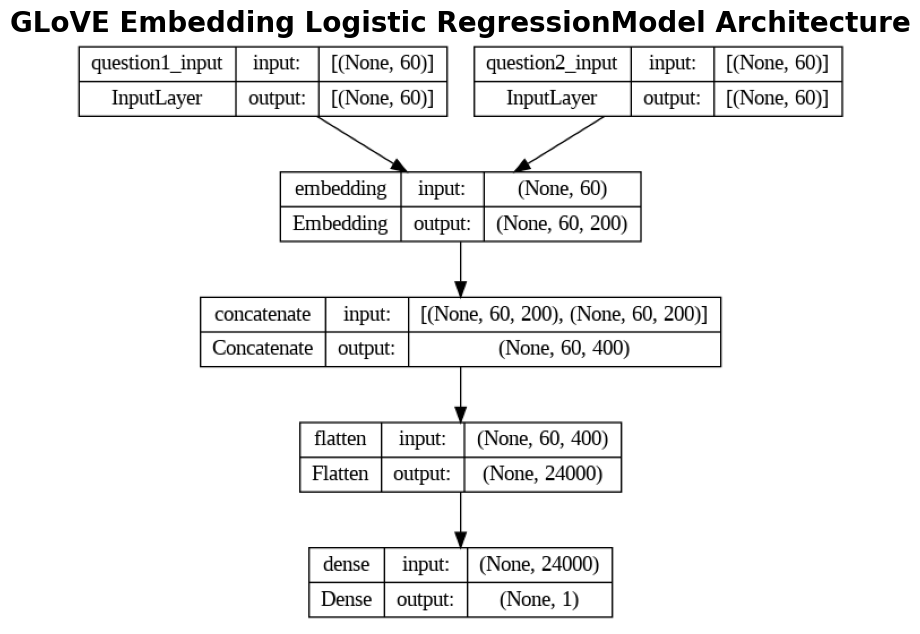

In [27]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Generate the model architecture plot
plot_model(model, to_file='logistic_regression_model_architecture.png', show_shapes=True)

# Load the image and add formatting
image = plt.imread('logistic_regression_model_architecture.png')
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)

# Add title and remove axes
ax.set_title('GLoVE Embedding Logistic RegressionModel Architecture', fontsize=20, fontweight='bold')
ax.axis('off')

# Add a border around the plot
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(True)

# Add a background color to the plot
ax.patch.set_facecolor('#f9f9f9')
ax.patch.set_alpha(0.9)

# Save and display the plot
plt.savefig('formatted_logistic_regression_model_architecture.png', bbox_inches='tight', pad_inches=0);

In [28]:
#model1
stopper= EarlyStopping(patience=3, monitor='val_loss')
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=3, save_best_only=True)

batch_size=2048
epochs=30

history=model.fit(
        [train_data_1, train_data_2], train_labels_reshaped,
         batch_size=batch_size,
         epochs=epochs,
         validation_data=([test_data_1, test_data_2], test_labels_reshaped),
         callbacks=[stopper, checkpointer],
         class_weight=class_weight,
         shuffle=True
         )

Epoch 1/30
158/158 [==============================] - ETA: 0s - loss: 0.6046 - accuracy: 0.6708 - precision: 0.5417 - recall: 0.7057
Epoch 1: val_loss improved from inf to 0.56387, saving model to model.weights.best.hdf5
158/158 [==============================] - 33s 168ms/step - loss: 0.6046 - accuracy: 0.6708 - precision: 0.5417 - recall: 0.7057 - val_loss: 0.5639 - val_accuracy: 0.7190 - val_precision: 0.6059 - val_recall: 0.6806
Epoch 2/30
158/158 [==============================] - ETA: 0s - loss: 0.5530 - accuracy: 0.7276 - precision: 0.6090 - recall: 0.7333
Epoch 2: val_loss did not improve from 0.56387
158/158 [==============================] - 13s 82ms/step - loss: 0.5530 - accuracy: 0.7276 - precision: 0.6090 - recall: 0.7333 - val_loss: 0.5721 - val_accuracy: 0.7065 - val_precision: 0.5759 - val_recall: 0.7745
Epoch 3/30
158/158 [==============================] - ETA: 0s - loss: 0.5311 - accuracy: 0.7452 - precision: 0.6296 - recall: 0.7531
Epoch 3: val_loss improved from 0.5

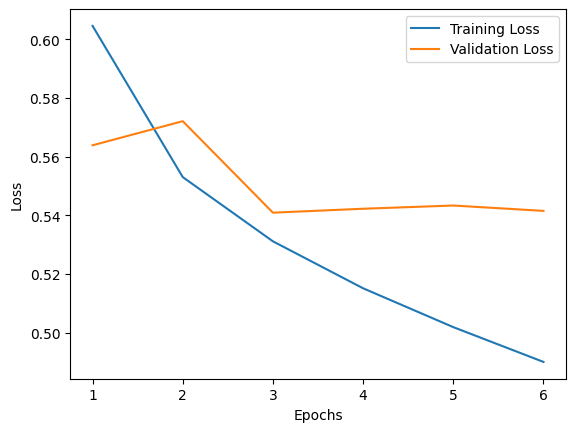

In [29]:
loss_values = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

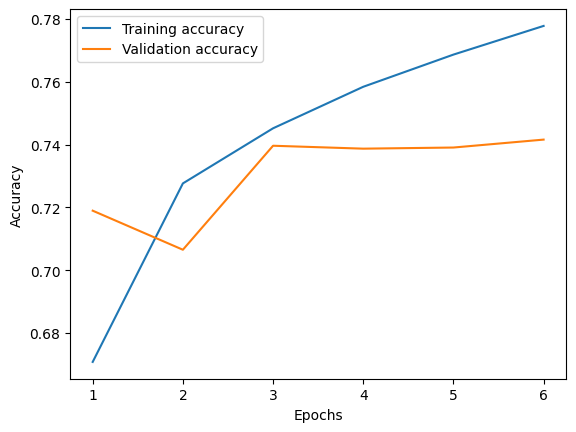

In [30]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

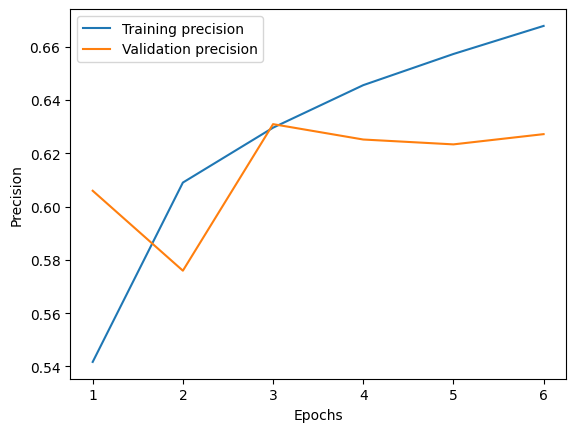

In [31]:
precision = history.history['precision']
val_precision = history.history['val_precision']
epochs = range(1, len(accuracy)+1)

plt.plot(epochs, precision, label='Training precision')
plt.plot(epochs, val_precision, label='Validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.show()

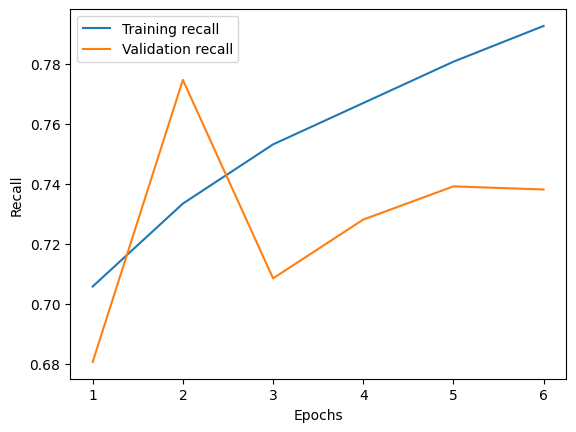

In [32]:
recall = history.history['recall']
val_recall = history.history['val_recall']
epochs = range(1, len(accuracy)+1)

plt.plot(epochs, recall, label='Training recall')
plt.plot(epochs, val_recall, label='Validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

In [33]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


In [53]:
test_chunks = pd.read_csv('/content/drive/MyDrive/COEN346_final_data/test.csv')[0:10]
test_chunks

<ipython-input-53-890e073c43f2>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  test_chunks = pd.read_csv('/content/drive/MyDrive/COEN346_final_data/test.csv')[0:10]


,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?
5,5,How are the two wheeler insurance from Bharti ...,I admire I am considering of buying insurance ...
6,6,How can I reduce my belly fat through a diet?,How can I reduce my lower belly fat in one month?
7,7,"By scrapping the 500 and 1000 rupee notes, how...",How will the recent move to declare 500 and 10...
8,8,What are the how best books of all time?,What are some of the military history books of...
9,9,After 12th years old boy and I had sex with a ...,Can a 14 old guy date a 12 year old girl?


In [52]:
test_chunks = pd.DataFrame(test_chunks)
test_chunks.head()
test_df = test_chunks

In [42]:
test_df['question1_cleaned'] = test_df['question1'].apply(lambda x : clean_text(x))
test_df['question2_cleaned'] = test_df['question2'].apply(lambda x : clean_text(x))

pbar = tqdm(total=len(df), desc='Stemming question1')
test_df['question1_cleaned'] = test_df['question1_cleaned'].apply(lambda x: (pbar.update(1), stem_words(x))[1])
pbar.close()

pbar = tqdm(total=len(df), desc='Stemming question2')
test_df['question2_cleaned']= test_df['question2_cleaned'].apply(lambda x: (pbar.update(1), stem_words(x))[1])
pbar.close()

pbar = tqdm(total=len(df), desc='Removing Stopwords:')
test_df['question1_cleaned']= test_df['question1_cleaned'].apply(lambda x: (pbar.update(1), remove_stopwords(x))[1])
pbar.close()

pbar = tqdm(total=len(df), desc='Removing Stopwords:')
test_df['question2_cleaned'] = test_df['question2_cleaned'].apply(lambda x: (pbar.update(1), remove_stopwords(x))[1])
pbar.close()

test_seq_que_1 = tokenizer.texts_to_sequences(test_df['question1_cleaned'].values)
test_seq_que_2 = tokenizer.texts_to_sequences(test_df['question2_cleaned'].values)

# Pad sequences to a fixed length
test_seq_que_1 = pad_sequences(test_seq_que_1, maxlen=max_len,  padding='post')
test_seq_que_2 = pad_sequences(test_seq_que_2, maxlen=max_len,  padding='post')

Removing Stopwords::   0%|          | 10/404287 [00:00<00:35, 11354.37it/s]


In [51]:
test_df_operational = test_df[['question1_cleaned', 'question2_cleaned']]
test_df_operational

,question1_cleaned,question2_cleaned
0,doe surfac pro 4 compar ipad pro,whi microsoft choos core m3 core i3 home su...
1,hair transplant age 24 much would cost,much cost doe hair transplant requir
2,best way send money china us,send money china
3,food emulsifi,food fibr
4,aberystwyth start read,start read
5,two wheeler insur bharti axa insur,admir consid buy insur
6,reduc belli fat diet,reduc lower belli fat one month
7,scrap 500 1000 rupe note rbi plan fight ...,recent move declar 500 1000 denomin lewin...
8,best book time,militari histori book time
9,12th year old boy sex 12 year old girl ...,14 old guy date 12 year old girl


In [ ]:
print(test_seq_que_2)

In [43]:
pred=model.predict([test_seq_que_1, test_seq_que_2])

1/1 [==============================] - 0s 102ms/step


In [45]:
pred_binary=(pred > 0.5).astype(int)

array([[0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0]])

In [54]:
test_df['is_duplicated'] = pred_binary

In [57]:
test_df[['question1', 'question2', 'is_duplicated']]

,question1,question2,is_duplicated
0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...,0
1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?,1
2,What but is the best way to send money from Ch...,What you send money to China?,1
3,Which food not emulsifiers?,What foods fibre?,0
4,"How ""aberystwyth"" start reading?",How their can I start reading?,1
5,How are the two wheeler insurance from Bharti ...,I admire I am considering of buying insurance ...,0
6,How can I reduce my belly fat through a diet?,How can I reduce my lower belly fat in one month?,1
7,"By scrapping the 500 and 1000 rupee notes, how...",How will the recent move to declare 500 and 10...,1
8,What are the how best books of all time?,What are some of the military history books of...,1
9,After 12th years old boy and I had sex with a ...,Can a 14 old guy date a 12 year old girl?,0
